## Validation #2: Feature tracking over a known, synthetic pixel offset, then calculate the difference between results and the ground truth

-- To be updated in the future work --

This method uses **one source image** from the planned feature tracking pair. A arbitrary, synthetic pixel offset is applied to that image. The original image and the processed image form a pair, and we perform feature tracking using this pair. we calculate the difference between the offsets found by the FT algorithm and the ground truth (which is the arbitrary pixel offset). The statistics of this difference can be compared with the metrics to determine whether these metrics really indicate better FT parameter combinations.

### Requirements and Limits

- There are several steps needed to bo done before running FT. Users have to determine a few parameters for creating the synthetic offset field and create the second image. 
- Since it does not use the actual results from the planned feature tracking pair, there is a concern that this metric may fail to find the best parameter set for the actual pair when surface conditions change during the pair period (e.g. from snow melt).

### Procedure

1. Prepare the source image as a Geotiff file. 

2. Determine the parameters for the synthetic offset field and use `gftt.create_synthetic_offset` and `gftt.apply_synthetic_offset` to create pixel-shifted image. See this notebook for details.

3. Perform feature tracking algorithm and collect the resulting velocity field ($V_x$ and $V_y$) as geotiff files.

4. Use `gftt.syn_shift_errors` to calculate the deviation from the ground truth (the synthetic shift field). See this notebook for details.

### Analysis

#### 1. Information, map area, importing modules

- Test area: **Kaskawulsh Glacier**
- Test packages: **CARST and Vmap**
- Test pair: **Landsat 8 20180304**

In [1]:
# Developer's setting
%load_ext autoreload
%autoreload 2

In [2]:
import gftt
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt
from pygeotools.lib import warplib
from matplotlib import cm

In [3]:
# source file
image_geotiff = '../../data/LS8/LC08_L1TP_061018_20180304_20180319_01_T1_B8_s.TIF'

In [4]:
src = rasterio.open(image_geotiff)

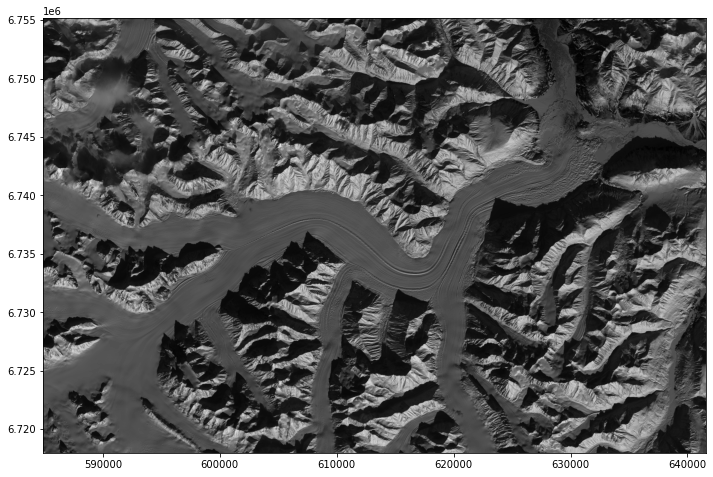

In [5]:
fig, ax0 = plt.subplots(1, 1, figsize=(12, 8))
show(src, cmap='gray', ax=ax0);

#### 2. Create pixel-shifted image

We use the defaul parameters below to create a sub-pixel shift field:

- block size = 500 pixels
- spline order = 1 (linear interpolation)

In [6]:
shift_arx, shift_ary = gftt.create_synthetic_offset(image_geotiff)
shift_arx

array([[0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       ...,
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8],
       [0.1, 0.1, 0.1, ..., 0.8, 0.8, 0.8]])

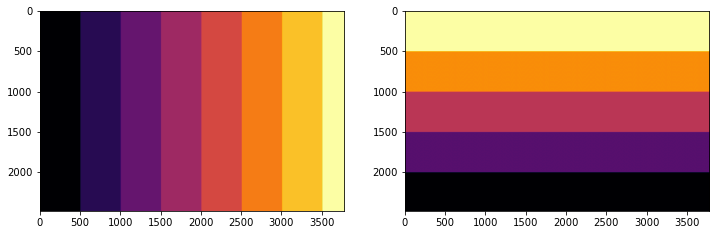

In [7]:
fig, ax1 = plt.subplots(1, 2, figsize=(12, 4))
ax1[0].imshow(shift_arx, cmap='inferno', vmin = 0.1, vmax = 0.8)
ax1[1].imshow(shift_ary, cmap='inferno', vmin = -0.5, vmax = -0.1);

In [8]:
shifted_image = gftt.apply_synthetic_offset(image_geotiff, shift_arx, shift_ary)

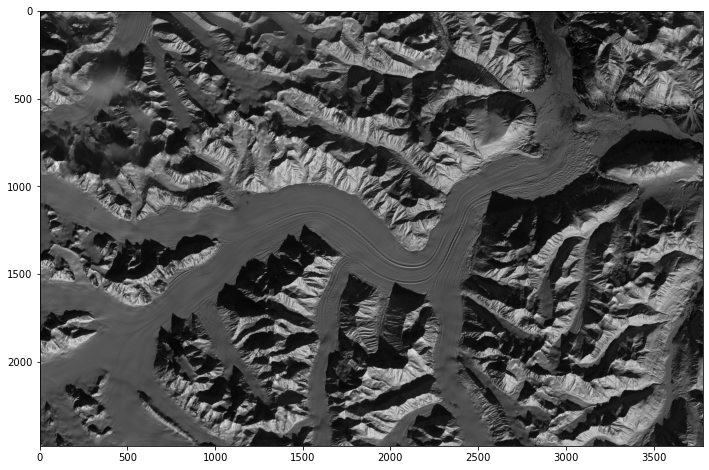

In [9]:
fig, ax2 = plt.subplots(1, 1, figsize=(12, 8))
ax2.imshow(shifted_image, cmap='gray');

Note that this should look really like the source image as the amount of offset is all within 1 pixel. We can save this image as a geotiff and perform feature tracking using whatever package to be tested.


In [10]:
kwds = src.profile
with rasterio.open('shifted_LS8_20180304.tif', 'w', **kwds) as dst:
    dst.write(shifted_image, 1)

In [11]:
kwds2 = src.profile
kwds2['dtype'] = 'float32'
with rasterio.open('shifted_array_x.tif', 'w', **kwds2) as dst:
    dst.write(shift_arx, 1)
with rasterio.open('shifted_array_y.tif', 'w', **kwds2) as dst:
    dst.write(shift_ary, 1)

#### 3. Run feature tracking using selected algorithm and parameter set

The pair to be used:
- `data/LS8/LC08_L1TP_061018_20180304_20180319_01_T1_B8_s.TIF`
- `./shifted_LS8_20180304.tif`

CARST results are stored in `data/synthetic_offset_results_carst`.

#### 4. Check the results

Here are paths to the FT results. We have 4 tests, and each of them uses a different kernel size. (8, 16, 36, and 52 pixels, respectively.)

In [12]:
result_x_geotiffs = ['../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vx.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne16/20180304-20180305_velo-raw_vx.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne36/20180304-20180305_velo-raw_vx.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne52/20180304-20180305_velo-raw_vx.tif']
result_y_geotiffs = ['../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vy.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne16/20180304-20180305_velo-raw_vy.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne36/20180304-20180305_velo-raw_vy.tif',
                     '../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne52/20180304-20180305_velo-raw_vy.tif']

As we read these files, we also warp the shift field (Section 2) in order to perform the pixel-to-pixel comparison (raster differencing) in the next sction. This step is necessary because a skip of 8 pixels is applied during the FT process. 

In [13]:
result_x = []
input_x  = []
result_y = []
input_y  = []

for fn in result_x_geotiffs:
    ds_list = warplib.memwarp_multi_fn(['shifted_array_x.tif', fn], res='last', extent='last', t_srs='last', r='near')
    input_x.append(ds_list[0].ReadAsArray(0))
    result_x.append(ds_list[1].ReadAsArray(0))
for fn in result_y_geotiffs:
    ds_list = warplib.memwarp_multi_fn(['shifted_array_y.tif', fn], res='last', extent='last', t_srs='last', r='near')
    input_y.append(ds_list[0].ReadAsArray(0))
    result_y.append(ds_list[1].ReadAsArray(0))


Warping all inputs to the following:
Resolution: 120.0
Extent: [584992.5, 6718102.5, 641392.5, 6755062.5]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs'
Resampling alg: near

1 of 2: shifted_array_x.tif
nl: 308 ns: 470 res: 120.000
2 of 2: ../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne8/20180304-20180305_velo-raw_vx.tif

Warping all inputs to the following:
Resolution: 120.0
Extent: [585052.5, 6718162.5, 641332.5, 6755002.5]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs'
Resampling alg: near

1 of 2: shifted_array_x.tif
nl: 307 ns: 469 res: 120.000
2 of 2: ../../data/synthetic_offset_results_carst/pair001_20180304-20180304syn_kerne16/20180304-20180305_velo-raw_vx.tif

Warping all inputs to the following:
Resolution: 120.0
Extent: [585202.5, 6718252.5, 641242.5, 6754852.5]
Projection: '+proj=utm +zone=7 +datum=WGS84 +units=m +no_defs'
Resampling alg: near

1 of 2: shifted_array_x.tif
nl: 305 ns: 467 res: 120.000
2 of 2: ../.

Also, CARST's offset measurements are in meters (or meters/day if date strings are given) instead of pixels, so we have to convert the unit in order to compare with the input shift field.

In [14]:
for i in range(len(result_x)):
    nodata_loc = result_x[i] < -9990       # NoDataValue locations
    result_x[i] /= -15                     # for unknown reason, CARST results seem to be sign-reversed
    result_y[i] /= 15
    result_x[i][nodata_loc] = -9999
    result_y[i][nodata_loc] = -9999

This figure shows what the results look like:

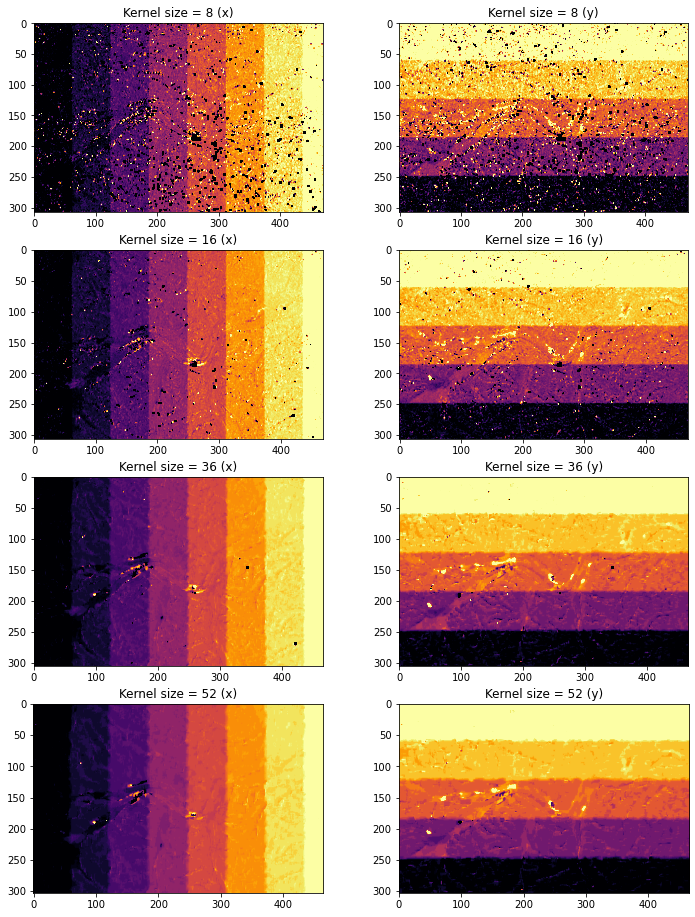

In [15]:
fig, ax3 = plt.subplots(4, 2, figsize=(12, 16))
title_string = [['Kernel size = 8 (x)', 'Kernel size = 8 (y)'], 
                ['Kernel size = 16 (x)', 'Kernel size = 16 (y)'],
                ['Kernel size = 36 (x)', 'Kernel size = 36 (y)'],
                ['Kernel size = 52 (x)', 'Kernel size = 52 (y)']]
for i in range(len(result_x)):
    ax3[i, 0].imshow(result_x[i], vmin = 0.1, vmax = 0.8, cmap='inferno')
    ax3[i, 0].set_title(title_string[i][0])
    ax3[i, 1].imshow(result_y[i], vmin = -0.5, vmax = -0.1, cmap='inferno')
    ax3[i, 1].set_title(title_string[i][1])

#### 5. Calculate the feature tracking deviation from the ground truth

Now we use `gftt.syn_shift_errors` to calculate the difference between the input shift field and the measured shift field. (This takes some time -- ~15-20 minutes)

In [16]:
diff_x = []
diff_y = []
z = []
thres_idx = []

for i in range(len(result_x)):
    tmp_x, tmp_y, tmp_z, tmp_idx = gftt.syn_shift_errors(ref_vx=input_x[i], vx=result_x[i], ref_vy=input_y[i], vy=result_y[i], plot=False)
    diff_x.append(tmp_x)
    diff_y.append(tmp_y)
    z.append(tmp_z)
    thres_idx.append(tmp_idx)

Start calculating KDE, this may take a while...
KDE Done!
Start calculating KDE, this may take a while...
KDE Done!
Start calculating KDE, this may take a while...
KDE Done!
Start calculating KDE, this may take a while...
KDE Done!


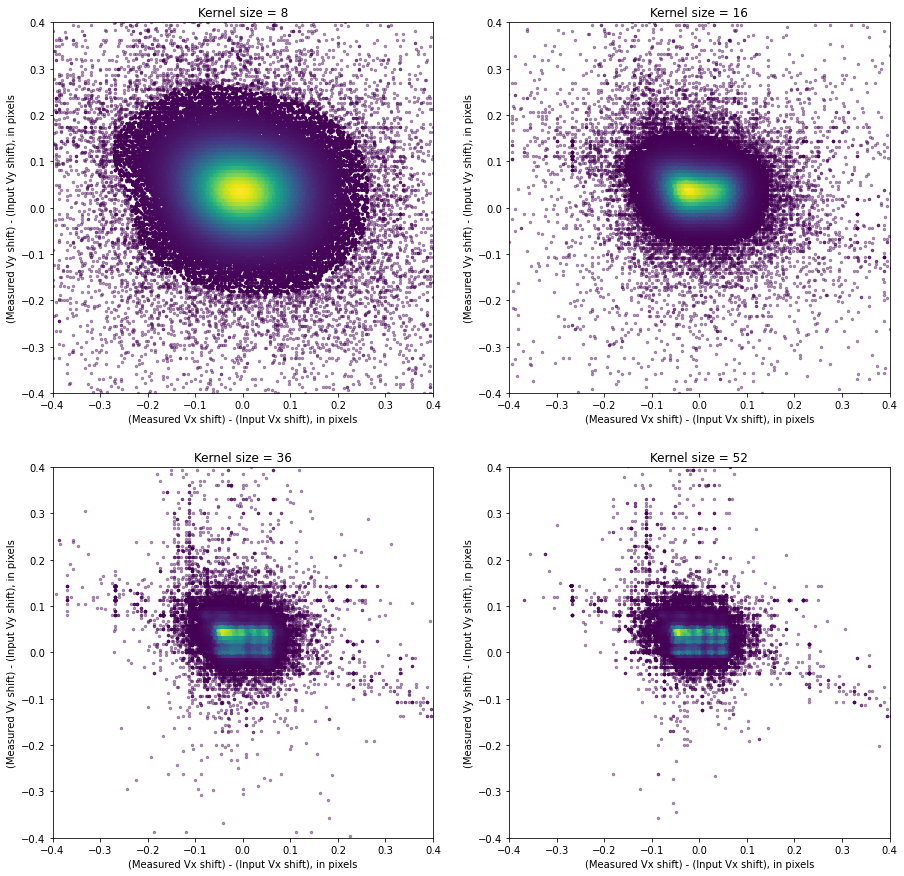

In [17]:
fig, ax4 = plt.subplots(2, 2, figsize=(15, 15))

viridis = cm.get_cmap('viridis', 12)
pt_style = {'s': 6, 'edgecolor': None}
xbound = (-0.4, 0.4)
ybound = (-0.4, 0.4)
title_string = ['Kernel size = 8', 
                'Kernel size = 16',
                'Kernel size = 36',
                'Kernel size = 52']

for i in range(len(result_x)):
    j = i // 2
    k = i % 2
    ax4[j, k].scatter(diff_x[i][thres_idx[i]],  diff_y[i][thres_idx[i]], c=z[i][thres_idx[i]], **pt_style)
    ax4[j, k].scatter(diff_x[i][~thres_idx[i]], diff_y[i][~thres_idx[i]], color=viridis(0), alpha=0.4, **pt_style)
    ax4[j, k].set_xlim(xbound)
    ax4[j, k].set_ylim(ybound)
    ax4[j, k].set_title(title_string[i])
    ax4[j, k].set_xlabel('(Measured Vx shift) - (Input Vx shift), in pixels')
    ax4[j, k].set_ylabel('(Measured Vy shift) - (Input Vy shift), in pixels')

In [20]:
for i in range(4):
    print(np.sum(thres_idx[i]) / diff_x[i].shape)

[0.91648297]
[0.94214847]
[0.9614299]
[0.96425707]


In [21]:
for i in range(4):
    print(title_string[i])
    print('Vx std: {:5f}  pixels'.format(np.std(diff_x[i], ddof=1)))
    print('Vy std: {:5f}  pixels'.format(np.std(diff_y[i], ddof=1)))

Kernel size = 8
Vx std: 0.309122  pixels
Vy std: 0.262493  pixels
Kernel size = 16
Vx std: 0.138230  pixels
Vy std: 0.111232  pixels
Kernel size = 36
Vx std: 0.055448  pixels
Vy std: 0.043165  pixels
Kernel size = 52
Vx std: 0.045505  pixels
Vy std: 0.033561  pixels


**Done!**

Other plots:

(-10.0, 10.0)

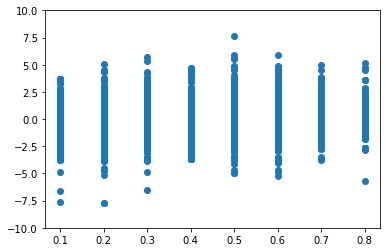

In [35]:
plt.scatter(input_x[0].flatten(), result_x[0].flatten())
plt.ylim(-10, 10)

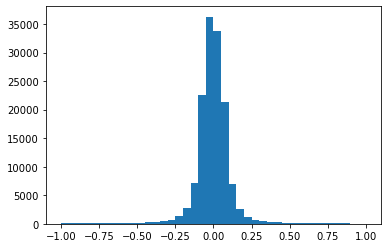

In [25]:
plt.hist(diff_x[0], bins=np.linspace(-1, 1, 41));

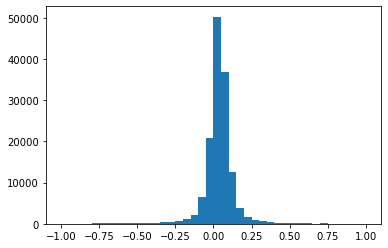

In [26]:
plt.hist(diff_y[0], bins=np.linspace(-1, 1, 41));